# CIS 519/419 Final Project
Team: Ruxuan (Cici) Ji (519, Pooja’s cohort), Joan Shaho (419, Pooja’s Cohort), Jiacheng Wei (519, Shubham’s cohort)

Project Mentor TA: Pooja




Instructions:

1.   Go to https://magenta.tensorflow.org/datasets/maestro#download
2.   Download maestro-v3.0.0-midi.zip (this may take some time)
3.   Unzip the folder
4.   Upload the unzipped folder to you google drive
5.   You are ready to run this colab doc


In [1]:
!pip install mido==1.2.9
!pip install pretty_midi
!pip install gensim==3.8
!pip install torchtext==0.4.0
!pip install unidecode
!pip install d2l

First, we import the required packages and libraries.

In [2]:
import pretty_midi
import numpy as np
import os
from mido import MidiFile
import re
import sys
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections

import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from gensim.models import Word2Vec
from nltk.corpus import brown
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors

from torch.utils.data import Dataset, DataLoader
from IPython.display import Image, YouTubeVideo
from torch.nn import functional as F
from d2l import torch as d2l

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


Here, we load the dataset obtained from google drive. Note that the MAESTRO dataset should be uploaded to google drive first.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here, we extract the notes from the piano instruments. After we get the array of piano roll, we convert them into dictionary and then the values of it into string. Then we will convert it into sequences of notes which will be used as inputs for our models. The notes present in the next timestep will act as the target.

In [4]:
def generate_dict_time_notes(file_names, fs=1.5):
  """ Generate map (dictionary) where the key is the index of the song file 
  name and the value is a piano roll (i.e. a 2D numpy array)
  
  Parameters
  ==========
  file_names : list
      List of midi file names
  fs : int
    Sampling frequency of the columns, i.e. each column is spaced apart
      by ``1./fs`` seconds.
  
  Returns
  =======
  dictionary of midi file names to piano_roll (in np.array)
  """
  
  # initialize dictionary
  piano_roll_dict = {}

  for i in range(len(file_names)):
      midi_file_name = file_names[i]
      
      # generate the dictionary entry for each file
      try:
          midi_pretty_format = pretty_midi.PrettyMIDI(midi_file_name)
          piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
          piano_roll = piano_midi.get_piano_roll(fs=fs)
          piano_roll_dict[i] = piano_roll
      except Exception as e:
          print(e)
          print("broken file : {}".format(midi_file_name))
          pass

  return piano_roll_dict

def toString(arr):
  result = ""
  for el in arr:
    result = result + str(el)
  
  return result

def process_notes_in_song(piano_roll_dict, dictionary, reverse_dict, dictionary_copy):
  """
  Iterate the dictionary of piano rolls and convert each one to a 2D array of 
  timesteps and notes played
  
  Parameters
  ==========
  piano_roll_dict : dict
    piano roll dictionary where the index is the midi file name and the value 
    is the corresponding piano_roll (as a np.array). This is the output of the
    function generate_dict_time_notes.
  
  dictionary: dict
    a dictionary object which will keep record of all the  
    
  reverse_dic: dict
    a dictionary from integers to the corresponding note combination 
    (in array form)
  
  dictionary_copy: dict
    a copy of the "dictionary" variable which stores the note combinations 
    based on the song they appear in. Each song is identified by its index when 
    all the songs are loaded

  Returns
  =======
  List of arrays where each array contains d inner arrays, where d is the 
  number of timesteps for a midi file. Each inner array i 
  (where 0 <= i < d) corresponds to the notes played at timestep i for a 
  specific a midi file.
  """

  # initialize the list
  list_of_keys_time = []
  
  count = 0
  for key in piano_roll_dict:
      # each sample has 128 rows (each one corresponding to a pitch). The 
      # columns correspond to timesteps. So by taking the transpose we are 
      # making the rows be the timesteps and the columns the notes being 
      # played on that timestep
      sample = piano_roll_dict[key].T
      keys_time = []

      dictionary_copy[count] = {}
      # for each time step create a compact array of notes that are played in 
      # that timestep
      for i in range(len(sample)):
        one_hot = np.zeros(128, dtype='int')
        notes = np.where(sample[i] > 1)[0]
        one_hot[notes] = 1
        word = toString(one_hot)
        ind = int(len(dictionary))
        if (word not in dictionary):
          dictionary[word] = ind
          dictionary_copy[count][ind] = True
          reverse_dict[ind] = one_hot
        else:
          ind = dictionary[word]
        keys_time.append(ind)
      
      list_of_keys_time.append(keys_time)
      count += 1
  return list_of_keys_time

def create_train_set(list_of_keys_time, reverse_dict, window_length = 50):
  """
  Iterate the list of timesteps to notes played and create the training set
  
  Parameters
  ==========
  list_of_keys_time : list
    list of timesteps to notes played (this is the output of the function 
    process_notes_in_song)

  reverse_dic: dict
    a dictionary from integers to the corresponding note combination 
    (in array form)

  window_length : int
    the number of timesteps to be used for predicting the next timestep
  Returns
  =======
  tuple of (array of note windows, array of notes played in the next timestep, 
  index of midi file name)
  """
  data = []

  for i in range(len(list_of_keys_time)):
    inner_list = list_of_keys_time[i]
    
    for j in range(len(inner_list) - window_length-1):
      item = (torch.tensor(inner_list[j:j+window_length], dtype=torch.long), inner_list[j+window_length])
      data.append(item)

  return data

def get_midi_files(percent = 1.0):
  """
  Get the directory paths of all midi files
  
  Parameters
  ==========
  percent : float
    the percentage of the songs to use

  Returns
  =======
  a list of all midi file directories
  """
  folder_path = '/content/drive/My Drive/maestro-v3.0.0/2018/'
  os.chdir(folder_path)
  midi_file_names = !ls
  arr = []
  for i in range(len(midi_file_names)):
    if (midi_file_names[i][0] != 'M'):
      continue
    arr.append(folder_path + midi_file_names[i])
  num_files = int(np.round(percent * len(arr)))
  midi_file_names = arr[:num_files]
  return midi_file_names

We build two dictionaries to represent note combinations by integers. Then we choose the portion of songs to use for training. Lastly, we seperate training songs into timesteps and combine timesteps into fixed-size windows which will form the training and validation sets

In [5]:
dictionary = {}
reverse_dict = {}
dictionary_copy = {}
midi_file_names = get_midi_files(percent=0.01)
piano_rolls = generate_dict_time_notes(midi_file_names, fs = 1.5)
timestep_notes_list = process_notes_in_song(piano_rolls, dictionary, reverse_dict, dictionary_copy)
data = create_train_set(timestep_notes_list, reverse_dict, window_length = 50)

In [6]:
# create split between training and validation set 
# and shuffle the data
split = int(0.7 * len(data))
np.random.shuffle(data)
train_data = data[:split]
val_data = data[split:]

Create the main train() function as well as helper functions

In [7]:
from torch import save
from torch import load
from os import path

def save_model(model, name):
  return save(model.state_dict(), name + ".pth")

def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

def train(args, model):
    # load the data and initialize the DataLoader objects
    train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=50, shuffle=True)

    # set the device
    device = torch.device(args.device)
    model = model.to(device)

    # initialize the weights
    model.apply(init_weights)

    # initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)
    
    # initialize the loss function
    lossFunc = nn.CrossEntropyLoss()
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    
    # loop through the number of epochs
    for epoch in range(args.epochs):
      model.train()
      running_loss = 0.
      correct, total = 0, 0 
      steps = 0
      for batch_idx, (data, target) in enumerate(train_loader):
        # map data and labels to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        
        # run forward pass
        output = model(data)

        # compute loss
        loss = lossFunc(output, target)

        # compute gradients
        loss.backward()

        # update model parameters
        optimizer.step()
        steps += 1
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, (data, target) in enumerate(val_loader):
            target = torch.autograd.Variable(target).long()
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            loss = lossFunc(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(val_loader))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(val_loader):.4f}, Validation Accuracy: {100*correct/total: .2f}%')
    
    # Plot loss and accuracy against number of epochs    
    plot1 = plt.figure(1)
    plt.plot(list(np.arange(1,args.epochs+1)), train_loss, label="Training Loss")
    plt.plot(list(np.arange(1,args.epochs+1)), validation_loss, label="Validation Loss")
    plt.xticks(np.arange(1,args.epochs+1,(args.epochs / 5)))
    plt.xlabel('Epoch #') 
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()

    plot2 = plt.figure(2)
    plt.plot(list(np.arange(1,args.epochs+1)), train_acc, label="Training Accuracy")
    plt.plot(list(np.arange(1,args.epochs+1)), validation_acc, label="Validation Accuracy")
    plt.xticks(np.arange(1,args.epochs+1,(args.epochs / 5)))
    plt.xlabel('Epoch #') 
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()

    plt.show()
    save(model.state_dict(), args.filename)

Create architecture for LSTM model

In [8]:
class LSTM(nn.Module):
  def __init__(self, args):
    super(LSTM, self).__init__()

    self.hidden_size = args.hidden_size
    self.vocab_size = args.vocab_size
    self.embed_size = args.embedding_length
    self.n_layers = args.layers
    self.device = args.device

    self.word_embeddings = nn.Embedding(args.vocab_size, self.embed_size)
    self.attention = nn.MultiheadAttention(self.embed_size, args.num_heads)
    self.lstm = nn.LSTM(self.embed_size, args.hidden_size, num_layers=self.n_layers, bidirectional=True, dropout=0.6)
    self.fc1 = nn.Linear(2*self.n_layers*self.hidden_size, 100)
    self.fc2 = nn.Linear(100, args.vocab_size)
    self.dropout = nn.Dropout(0.6)

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    att_outputs, _ = self.attention(input.contiguous(), input.contiguous(), input.contiguous())
    att_outputs = F.relu(att_outputs)
    hidden = (torch.randn(2*self.n_layers, input.shape[1], self.hidden_size).to(self.device),
            torch.randn(2*self.n_layers, input.shape[1], self.hidden_size).to(self.device))
    output, hidden = self.lstm(att_outputs, hidden)
    h_n = hidden[0].permute(1, 0, 2)
    outputs = h_n.contiguous().view(h_n.shape[0], -1)
    outputs = F.relu(outputs)
    linear_output1 = self.fc1(outputs)
    linear_output1 = F.relu(linear_output1)
    logits = self.fc2(linear_output1)
    return logits

Train the LSTM model

Epoch: 1,  Training Loss: 5.5552, Training Accuracy:  6.26%
Validation Loss: 5.5413, Validation Accuracy:  25.10%
Epoch: 2,  Training Loss: 5.5132, Training Accuracy:  26.78%
Validation Loss: 5.4894, Validation Accuracy:  27.53%
Epoch: 3,  Training Loss: 5.4338, Training Accuracy:  27.65%
Validation Loss: 5.3901, Validation Accuracy:  27.53%
Epoch: 4,  Training Loss: 5.2876, Training Accuracy:  27.65%
Validation Loss: 5.1818, Validation Accuracy:  27.53%
Epoch: 5,  Training Loss: 5.0067, Training Accuracy:  27.65%
Validation Loss: 4.8369, Validation Accuracy:  27.53%


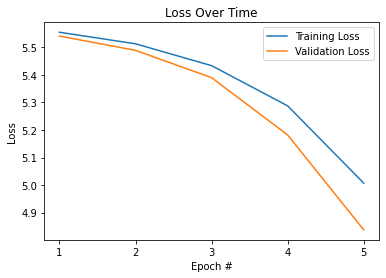

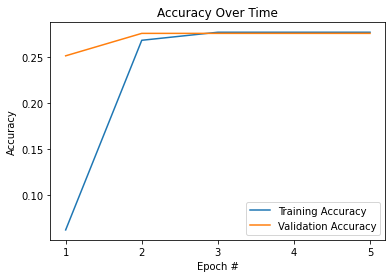

In [9]:
class Args(object):
    pass

args = Args();
args.learning_rate = 0.0001
args.epochs = 405
args.device = "cuda:0"
args.hidden_size = 128
args.embedding_length = 128
args.layers = 2
args.num_heads = 1
args.vocab_size = len(dictionary)
args.filename = "LSTMModel-1.5-0.01.pth"

lstm_model = LSTM(args)
train(args, lstm_model)

Helper function for loading pre-trained models

In [10]:
from torch import load
def load_model(name, args, device_name='cpu'):
    """
    @Brief: load a model saved in the ".pth" or ".pt" formats
    @Inputs:
        name (str): name of the model (without the extension)
        args (Args Object): set of arguments describing information such as the hyperparameters of the model
        device_name (str): name of the device i.e: 'cpu', 'cuda:0', that you would want to run the model on.
    @Outputs:
        r (nn.Module): a Pytorch model of either "BasicCNNClassifier" or "MyBestCNNClassifier" (depend on "name" input) 
            with pretrained wieghts.
    """
    # In case students set input name = "*.pth" 
    r = LSTM(args)
    r.load_state_dict(load(name + ".pth", map_location=device_name))
    return r

Re-form the train set without shuffling the data this time. 

In [16]:
dictionary = {}
reverse_dict = {}
dictionary_copy = {}
midi_file_names = get_midi_files(percent=0.01)
piano_rolls = generate_dict_time_notes(midi_file_names, fs = 1.5)
timestep_notes_list = process_notes_in_song(piano_rolls, dictionary, reverse_dict, dictionary_copy)
data = create_train_set(timestep_notes_list, reverse_dict, window_length = 50)

split = int(0.7 * len(data))
train_data = data[:split]
val_data = data[split:]

seed = train_data[0][0]

Generate new music 

In [18]:
args = Args();
args.learning_rate = 0.0001
args.epochs = 405
args.device = "cuda:0"
args.hidden_size = 128
args.embedding_length = 128
args.layers = 2
args.num_heads = 1
args.vocab_size = len(dictionary)
args.filename = "LSTMModel-1.5-0.01.pth"

# model = load_model("/content/drive/My Drive/maestro-v3.0.0/2018/LSTMModel-1.5-0.01", args, args.device)
model = load_model("/content/LSTMModel-1.5-0.01", args, args.device)

# Generate the new music
X_new = seed
preds = []
new_dict = dictionary
new_notes = 0
for j in range(100):
  model.eval()
  input_ = X_new[j:j+50].reshape(1, -1).to(args.device)
  output = model(input_)
  category = torch.argmax(output).item()

  # check if output is part of the first song 
  # (which is where the seed is taken from)
  if (category not in dictionary_copy[0]):
    new_notes += 1
  prediction = reverse_dict[category]
  X_new = X_new.tolist()
  X_new.append(category)
  preds.append(prediction)
  X_new = torch.tensor(X_new)

print(X_new[50:])
print(new_notes)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
0


Find the number of non-empty timesteps in the generated music

In [26]:
num = len(np.nonzero(X_new[50:]))
denom = len(X_new[50:])
print(num / denom)

0.0


Add one pitch at the end as the signal to stop if the notes generated are all empty.

In [32]:
X_n = np.hstack((X_new[50:],[1]))

The following two blocks transform the sequence of piano rolls to a midi file.

In [30]:
def piano_roll_to_pretty_midi(piano_roll, fs=1.5, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''

    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    print(np.diff(piano_roll).T)

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity # 1/0
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [31]:
def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=0, fs=1.5, max_generated=100):
  array_piano_roll = np.zeros((max_generated+1, 128), dtype=np.int16)
  for index, combo in enumerate(generate[start_index:]):
    array_piano_roll[index] = combo

  generate_to_midi = piano_roll_to_pretty_midi(array_piano_roll.T, fs=fs)
  for note in generate_to_midi.instruments[0].notes:
    note.velocity = 100
  generate_to_midi.write(midi_file_name)

write_midi_file_from_generated(np.array(preds, dtype=int), midi_file_name = "1_song_fs_1.5.mid", start_index=0, fs=1.5, max_generated = 101)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Note that the .mid file with the generated song might be in the "/content/drive/My Drive/maestro-v3.0.0/2018/" directory